In [1]:
import sys 
import os
import geopandas as gpd
from shapely.geometry import mapping
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [4]:
rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from era5_weather import clean_column_names, get_weather_data_df, WeatherAPI
from nex_gddp_cmip6 import get_nex_dataset, TIME_OPTIMIZED_SCENARIOS, AVAILABLE_VARIABLES, select_region
from utils import states_gdf

In [5]:
# sample region
#geodf = load_region('../assets/data/external/MI_avas.geojson')

region = 'easternmountain'
orchards_shape_file_path = f"../data/processed/gdf_{region}_polygons/gdf_{region}_polygons.shp"
orchards_gdf = gpd.read_file(orchards_shape_file_path)

In [6]:
orchards_gdf.geometry

0    POLYGON ((-82.37697 36.04470, -82.12014 36.063...
1    POLYGON ((-78.75577 39.52645, -78.33536 39.608...
Name: geometry, dtype: geometry

In [7]:
# https://gis.stackexchange.com/questions/343725/convert-geojson-to-geopandas-geodataframe

# init weather object
weather = WeatherAPI(orchards_gdf.geometry, 'US/Central')

## Get Region Area

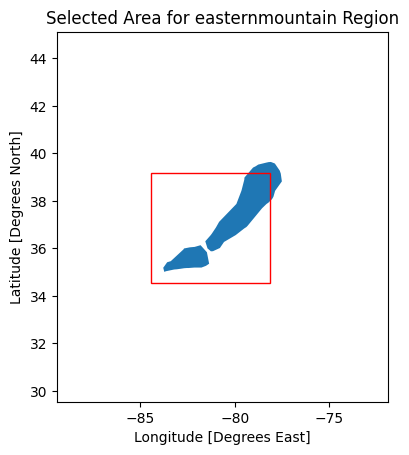

In [8]:
## Get Coordinates: 

# https://pythongis.org/part2/chapter-06/nb/03-geometric-manipulation.html#:~:text=In%20a%20GeoDataFrame%20%2C%20the%20envelope,bounding%20rectangle%20for%20each%20geometry.&text=In%20order%20to%20get%20the,bounding%20rectangle%20for%20that%20polygon.
bbox = orchards_gdf.geometry.unary_union.bounds
# Add a 10% buffer to the bounding box
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
bbox = (
    bbox[0] - 0.1 * width,
    bbox[1] - 0.1 * height,
    bbox[2] + 0.1 * width,
    bbox[3] + 0.1 * height,
)
north = bbox[3]
south = bbox[1]
east = bbox[2]
west = bbox[0]

# Visualize Selected Region
ax = orchards_gdf.plot()
ax.set_xlim(west-5,east+5)
ax.set_ylim(south-5,north+5)

rect = patches.Rectangle((west, south), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title(f'Selected Area for {region} Region')
ax.set_xlabel('Longitude [Degrees East]')
ax.set_ylabel('Latitude [Degrees North]')
plt.show()

In [11]:
# https://www.freecodecamp.org/news/strftime-in-python/
start_date = datetime.fromisoformat("2023-01-01 00:00:00")
end_date = datetime.fromisoformat("2023-12-31 00:00:00")

# frequency: H (hourly), D (daily), or M (monthly). If no frequency is passed, the API service assumes Hourly
weather_area_ds = weather._get_area_data(start_date = start_date, end_date = end_date, frequency = 'H', model = 'era5')

In [12]:
weather_area_ds 

<xarray.Dataset> Size: 380kB
Dimensions:                          (latitude: 22, longitude: 30, time: 12)
Coordinates:
  * latitude                         (latitude) float32 88B 40.0 39.75 ... 34.75
  * longitude                        (longitude) float32 120B -84.25 ... -77.0
  * time                             (time) datetime64[ns] 96B 2023-01-31 ......
Data variables:
    temperature                      (time, latitude, longitude) float32 32kB ...
    dewpoint_temperature             (time, latitude, longitude) float32 32kB ...
    wind_speed                       (time, latitude, longitude) float32 32kB ...
    surface_pressure                 (time, latitude, longitude) float32 32kB ...
    surface_solar_radiation          (time, latitude, longitude) float32 32kB ...
    surface_thermal_radiation        (time, latitude, longitude) float32 32kB ...
    surface_net_solar_radiation      (time, latitude, longitude) float32 32kB ...
    surface_direct_solar_radiation   (time, latitude, longitude) float32 32kB ...
    surface_diffuse_solar_radiation  (time, latitude, longitude) float32 32kB ...
    total_cloud_cover                (time, latitude, longitude) float32 32kB ...
    total_precipitation              (time, latitude, longitude) float32 32kB ...
    relative_humidity                (time, latitude, longitude) float32 32kB ...
Attributes:
    Source:       ECMWF ERA5 reanalysis data - Copernicus Climate Change Serv...
    Conventions:  CF-1.6
    Institution:  Source data processed by Oikolab for cloud-optimized storag...
    model:        era5

In [13]:
weather_df = weather._create_dataframe(weather_area_ds)

In [21]:
# save data into disk
weather_df.to_csv(f'../data/external/eras5/{region}_area_orchards.csv')

NameError: name 'weather_df' is not defined

In [17]:
weather_df.shape

(7920, 19)

In [18]:
weather_df.head()

,lat,lon,timestamp_utc,temperature_degC,dewpoint_temperature_degC,wind_speed_m_per_s,surface_pressure_Pa,surface_solar_radiation_W_per_m2,surface_thermal_radiation_W_per_m2,total_solar_radiation,surface_direct_solar_radiation,surface_diffuse_solar_radiation,total_cloud_cover,total_precipitation_mm_of_water_equivalent,relative_humidity_0_1,model,timestamp_local,snowfall_mm_of_water_equivalent,snow_depth_mm_of_water_equivalent
0,40.0,-84.25,2023-01-31 00:00:00+00:00,2.739063,-0.629215,3.799925,98239.281250,69.808281,288.880890,51.397179,32.985416,36.825272,0.796505,0.197237,0.792511,era5,2023-01-30 18:00:00-06:00,None,None
1,40.0,-84.25,2023-02-28 00:00:00+00:00,4.426838,-2.279801,4.440866,98357.429688,132.344116,269.826416,110.429642,90.855087,41.490471,0.626845,0.096465,0.637549,era5,2023-02-27 18:00:00-06:00,None,None
2,40.0,-84.25,2023-03-31 00:00:00+00:00,5.183824,-1.248045,4.245170,98341.625000,164.835526,277.194550,136.913818,103.497704,61.339520,0.631519,0.196081,0.659313,era5,2023-03-30 19:00:00-05:00,None,None
3,40.0,-84.25,2023-04-30 00:00:00+00:00,11.815882,3.573797,3.808577,98244.453125,226.765411,300.381561,185.015945,149.845749,76.920952,0.581361,0.117340,0.601972,era5,2023-04-29 19:00:00-05:00,None,None
4,40.0,-84.25,2023-05-31 00:00:00+00:00,16.661293,8.461324,3.272094,98370.593750,261.448578,327.844666,209.869598,179.004517,82.444633,0.545027,0.084550,0.610554,era5,2023-05-30 19:00:00-05:00,None,None


## function: _get_location_data


C:\Users\manwi\AppData\Local\Temp\ipykernel_99712\1133177969.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lat, centroid_lon = weather.geometry.centroid.y.values, weather.geometry.centroid.x.values


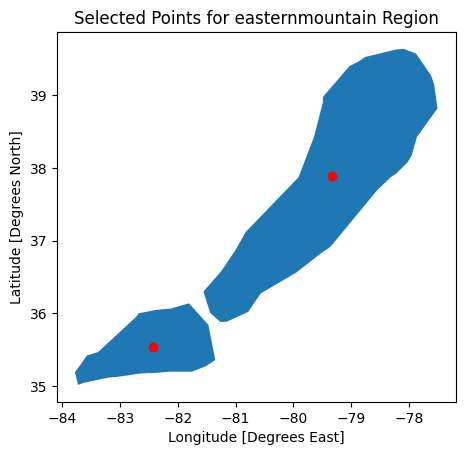

In [16]:
centroid_lat, centroid_lon = weather.geometry.centroid.y.values, weather.geometry.centroid.x.values

# Visualize Selected Points
ax = orchards_gdf.plot()
plt.plot(centroid_lon,centroid_lat, color = 'r', marker = 'o', linewidth = 0)

ax.set_title(f'Selected Points for {region} Region')
ax.set_xlabel('Longitude [Degrees East]')
ax.set_ylabel('Latitude [Degrees North]')
plt.show()

In [17]:
start_date = datetime.fromisoformat("2023-01-01 00:00:00")
end_date = datetime.fromisoformat("2023-12-31 00:00:00")

weather_location_df = weather._get_location_data(start_date = start_date, end_date = end_date, frequency = 'H', model = 'era5')

e:\OneDrive - Umich\MADS\Courses\SIADS_699\um-mads\src\era5_weather.py:187: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat, lon = self.geometry.centroid.y.values, self.geometry.centroid.x.values


In [20]:
# save data into disk
weather_location_df.to_csv(f'../data/external/eras5/{region}_points_orchards.csv')

In [18]:
weather_location_df.shape

(24, 18)

In [19]:
weather_location_df.head()

,"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),surface_pressure (Pa),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),surface_net_solar_radiation (W/m^2),surface_direct_solar_radiation (W/m^2),surface_diffuse_solar_radiation (W/m^2),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),relative_humidity (0-1),snowfall (mm of water equivalent),snow_depth (mm of water equivalent)
2023-01-31,"(35.54020803744302, -82.42694383418464)",era5,759.41,-5.0,5.57,0.23,2.45,92928.78,98.32,284.47,86.67,63.07,35.26,0.65,0.17,0.72,0.00,0.00
2023-02-28,"(35.54020803744302, -82.42694383418464)",era5,759.41,-5.0,8.91,2.29,2.71,93079.04,126.50,299.76,111.28,79.10,47.41,0.71,0.14,0.67,0.01,0.05
2023-03-31,"(35.54020803744302, -82.42694383418464)",era5,759.41,-5.0,9.38,0.19,2.68,92932.30,196.41,283.00,172.08,142.28,54.13,0.52,0.10,0.58,0.00,0.00
2023-04-30,"(35.54020803744302, -82.42694383418464)",era5,759.41,-5.0,13.38,5.26,2.27,92993.60,231.99,307.28,199.52,169.55,62.45,0.55,0.20,0.64,0.00,0.00
2023-05-31,"(35.54020803744302, -82.42694383418464)",era5,759.41,-5.0,16.09,10.06,2.25,93023.52,241.39,332.43,200.91,152.37,89.01,0.70,0.09,0.70,0.00,0.00


In [25]:
# checking shape from orchards_gdf
dyrus = weather.geometry.to_crs("EPSG:4326")
lat, lon = dyrus.centroid.y.values, dyrus.centroid.x.values
print(f"lat: {lat}, lon: {lon}")     

lat: [35.54020804 37.89188023], lon: [-82.42694383 -79.33022958]


C:\Users\manwi\AppData\Local\Temp\ipykernel_116724\2709532432.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat, lon = dyrus.centroid.y.values, dyrus.centroid.x.values


In [26]:
oddone = weather.geometry
lat, lon = oddone.centroid.y.values, oddone.centroid.x.values
print(f"lat: {lat}, lon: {lon}")

lat: [35.54020804 37.89188023], lon: [-82.42694383 -79.33022958]


C:\Users\manwi\AppData\Local\Temp\ipykernel_116724\3097027570.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat, lon = oddone.centroid.y.values, oddone.centroid.x.values
